# What does this Notebook do?

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point
import warnings
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

## Read SWE stations NetCDF

In [2]:
SWE_stations_raw = xr.open_dataset("/Users/lla068/Desktop/data_driven_forecasting/data/snow_obs_Canada/canadian_snow_survey_data_1928to2020_noqc_noduplicates.nc")
display(SWE_stations_raw)

<xarray.Dataset>
Dimensions:           (station_id: 2659, time: 33816)
Coordinates:
  * time              (time) datetime64[ns] 1928-01-01T18:00:00 ... 2020-07-31T18:00:00
  * station_id        (station_id) object 'ALE-05AA801' ... 'MB-05TD707'
Data variables:
    lat               (station_id) float32 ...
    lon               (station_id) float32 ...
    elevation         (station_id) float32 ...
    source            (station_id) object ...
    snw               (time, station_id) float32 ...
    snd               (time, station_id) float32 ...
    data_flag_1       (time, station_id) |S1 ...
    data_flag_2       (time, station_id) |S1 ...
    data_flag_qc_1    (time, station_id) |S1 ...
    data_flag_qc_2    (time, station_id) |S1 ...
    station_name      (station_id) object ...
    merge_key         (station_id) float64 ...
    station_name_bis  (station_id) object ...
    station_id_bis    (station_id) object ...
    station_name_ter  (station_id) object ...
    station_id_ter    (station_id) object ...
    merge_snw         (time, station_id) float32 ...
    merge_snd         (time, station_id) float32 ...
    type_mes          (station_id) float32 ...
Attributes:
    Conventions:     CF-1.5
    title:           2016 update of Canadian historical snow survey dataset
    history:         2017-04-18T11:24:42: Convert from original format Text t...
    institution:     Processed by Environment and Climate Change Canada using...
    source:          Manual snow survey (gravimetry) and snow pillow observat...
    references:      MSC = Braaten, R. Canadian Snow Water Equivalent Databas...
    comment:         See ECCC internal report by Fang (2017)
    redistribution:  For internal use only (ECCC and Ouranos).

In [3]:
# Re-organize dataset if needed (i.e., need to have time, station_id, lon, lat and station_name as coordinates and snw as variable)

SWE_stations = SWE_stations_raw.assign_coords({'lon':SWE_stations_raw.lon, 'lat':SWE_stations_raw.lat, 'station_name':SWE_stations_raw.station_name}).snw
SWE_stations = SWE_stations.to_dataset()

display(SWE_stations)

<xarray.Dataset>
Dimensions:       (station_id: 2659, time: 33816)
Coordinates:
    lat           (station_id) float32 49.266666 49.733334 ... 55.710052
    lon           (station_id) float32 -114.35 -114.6 ... -95.23417 -97.88888
    station_name  (station_id) object 'WEST CASTLE BUSH' ... 'SNOW PILOT AT THOMPSON SERVICE CENTER'
  * time          (time) datetime64[ns] 1928-01-01T18:00:00 ... 2020-07-31T18:00:00
  * station_id    (station_id) object 'ALE-05AA801' ... 'MB-05TD707'
Data variables:
    snw           (time, station_id) float32 ...

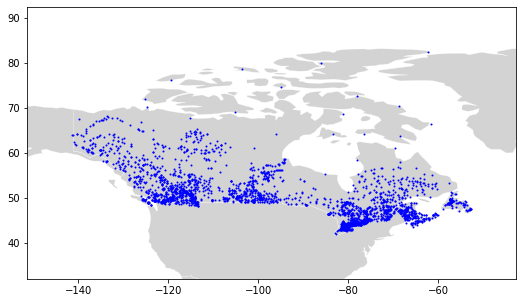

In [4]:
# Plot stations available

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
plt.scatter(SWE_stations.lon, SWE_stations.lat, color='b', s=1)
minx, miny, maxx, maxy = min(SWE_stations.lon),min(SWE_stations.lat),max(SWE_stations.lon),max(SWE_stations.lat)
ax.set_xlim(minx - 10, maxx + 10)
ax.set_ylim(miny - 10, maxy + 10);

In [5]:
# # Plotting raw data availability at regular snow season dates
# 
# fig, axs = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(15,15))
# elem = -1
# colors = ['purple','blue','deepskyblue','green','gold','orange','red']
# for m in [11,12,1,2,3,4,5]:
#     elem += 1
#     # 1st of month plots
#     datafirstmonth = SWE_stations.snw.sel(time=( (SWE_stations['time.month'] == m) & (SWE_stations['time.day'] == 1) ))
#     datafirstmonthcount = datafirstmonth.count(dim='station_id')
#     axs[elem,0].bar(datafirstmonthcount['time.year'], datafirstmonthcount.data, color=colors[elem])
#     if m == 5:
#         axs[elem,0].set_ylabel('No. available stations')
#     axs[elem,0].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(1), fontweight='bold')
#     # 15th of month plots
#     datafifteenthmonth = SWE_stations.snw.sel(time=( (SWE_stations['time.month'] == m) & (SWE_stations['time.day'] == 15) ))
#     datafifteenthmonthcount = datafifteenthmonth.count(dim='station_id')
#     axs[elem,1].bar(datafifteenthmonthcount['time.year'], datafifteenthmonthcount.data, color=colors[elem])
#     axs[elem,1].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(15), fontweight='bold')
# plt.tight_layout();

## Read selected basins

In [6]:
%store -r basinno

%store -r basins
display(basins)

%store -r randomcolors

,Station,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea
0,05BB001,BOW RIVER AT BANFF,05BB001_1,2209.593735,340.817572,"POLYGON Z ((-116.45854 51.72693 0.00000, -116....",NaN
1,08NG065,KOOTENAY RIVER AT FORT STEELE,08NG065_1,11469.599609,938.643005,"POLYGON Z ((-115.65527 49.61030 0.00000, -115....",None
2,08KB001,FRASER RIVER AT SHELLEY,08KB001_1,32436.599609,1968.160034,"POLYGON Z ((-122.61240 53.99059 0.00000, -122....",None
3,09CD001,YUKON RIVER ABOVE WHITE RIVER,09CD001_1,149347.229154,3246.830544,"POLYGON Z ((-139.85081 63.13083 0.00000, -139....",NaN
4,09DD003,STEWART RIVER AT THE MOUTH,09DD003_1,51023.181464,1945.439489,"POLYGON Z ((-136.56373 64.34605 0.00000, -136....",NaN
5,02GA041,GRAND RIVER NEAR DUNDALK,02GA041_1,66.500000,NaN,"POLYGON Z ((-80.33917 44.24417 0.00000, -80.33...",NaN
6,02OJ007,RICHELIEU (RIVIERE) AUX RAPIDES FRYERS,02OJ007_1,22000.000000,NaN,"POLYGON Z ((-73.27833 45.41333 0.00000, -73.26...",NaN
7,01AD004,SAINT JOHN RIVER AT EDMUNDSTON,01AD004_1,15500.000000,NaN,"POLYGON Z ((-69.25917 47.82333 0.00000, -69.25...",NaN
8,02LG005,GATINEAU (RIVIERE) AUX RAPIDES CEIZUR,02LG005_1,6840.000000,NaN,"POLYGON Z ((-75.42667 48.17250 0.00000, -75.42...",NaN


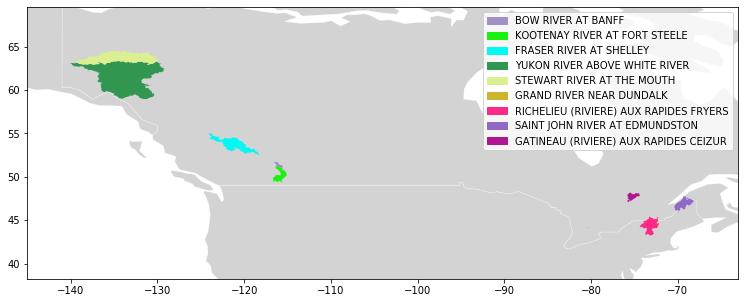

In [7]:
# Plot the selected basins

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
patches = []

for b in basinno:
    basins.loc[basins['Station'] == b].plot(ax=ax, facecolor=randomcolors[b][0])
    patches += [mpatches.Patch(color=randomcolors[b][0], label=basins.loc[basins['Station'] == b].StationNam.values[0])]
minx, miny, maxx, maxy = min(basins.geometry.bounds.minx),min(basins.geometry.bounds.miny),max(basins.geometry.bounds.maxx),max(basins.geometry.bounds.maxy)
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)
plt.legend(handles=patches);

## Select SWE stations in basins

,station_id,lon,lat,geometry
0,ALE-05AA801,-114.349998,49.266666,POINT (-114.35000 49.26667)
1,ALE-05AA803,-114.599998,49.733334,POINT (-114.60000 49.73333)
2,ALE-05AA805,-114.349998,49.266666,POINT (-114.35000 49.26667)
3,ALE-05AA806,-114.633331,49.816666,POINT (-114.63333 49.81667)
4,ALE-05AA809,-114.016670,49.349998,POINT (-114.01667 49.35000)
...,...,...,...,...
2654,MB-06FD680,-94.159012,58.674084,POINT (-94.15901 58.67408)
2655,MB-06FD702,-95.439445,57.569443,POINT (-95.43945 57.56944)
2656,MB-06FA703,-97.830040,57.331215,POINT (-97.83004 57.33121)
2657,MB-05UF597,-95.234169,56.362778,POINT (-95.23417 56.36278)


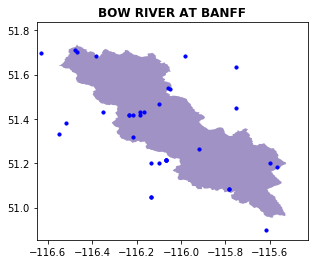

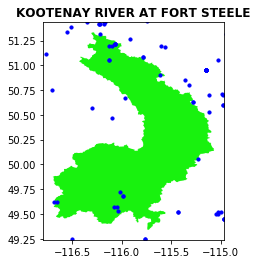

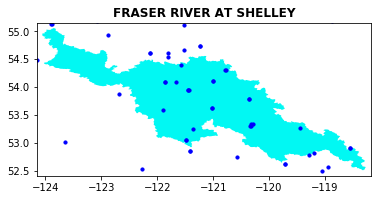

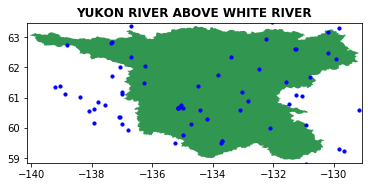

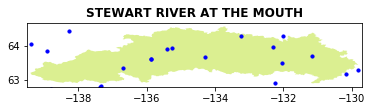

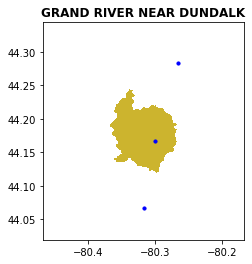

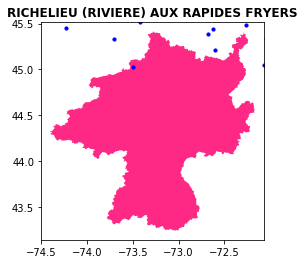

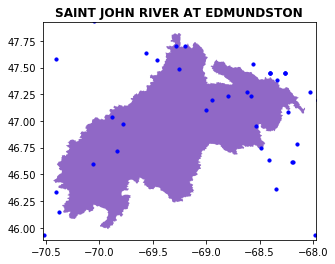

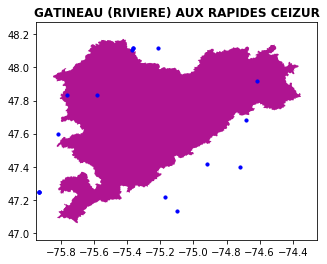

In [8]:
# Convert SWE stations DataArray to GeoDataFrame

data = {'station_id': SWE_stations.station_id.data, 
        'lon': SWE_stations.lon.data, 
        'lat': SWE_stations.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)

# Plot selected basin and SWE stations in and within an area around basin
for b in basinno:
    minx, miny, maxx, maxy = basins.loc[basins['Station'] == b].geometry.total_bounds
    fig, ax = plt.subplots()
    basins.loc[basins['Station'] == b].plot(ax=ax, facecolor=randomcolors[b][0])
    SWE_stations_gdf.plot(ax=ax, marker='o', color='b', markersize=10)
    ax.set_xlim(minx - .1, maxx + .1)
    ax.set_ylim(miny - .1, maxy + .1)
    ax.set_title(basins.loc[basins['Station'] == b].StationNam.values[0], fontweight='bold');

In [9]:
# Extract SWE stations within (buffer of) basin and save info to DataFrame
# Note: Two extraction options below

buffer = 0 # 1) extract SWE stations only within basin
# buffer = 1 # 2) extract SWE stations within a buffer of basin

if buffer == 1:
    basins_buffer = {}

elem = -1
    
for b in basinno:
    
    elem += 1
    
    # 1) Extract SWE stations within basin only
    if buffer == 0:
        SWEstationsinbasin_mask = SWE_stations_gdf.within(basins.loc[basins['Station'] == b].loc[elem,"geometry"])
    
    # 2) Extract SWE stations within specified buffer of basin
    elif buffer == 1:
        basinbuffer = basins.loc[basins['Station'] == b].buffer(.06)
        SWEstationsinbasin_mask = SWE_stations_gdf.within(basinbuffer.loc[elem])
        basins_buffer[b] = basinbuffer
    
    if b == basinno[0]:
        SWE_stations_inbasins_gdf = SWE_stations_gdf.loc[SWEstationsinbasin_mask]
        SWE_stations_inbasins_gdf = SWE_stations_inbasins_gdf.assign(basin=b)
    else:
        SWE_stations_inbasins_gdf_basin = SWE_stations_gdf.loc[SWEstationsinbasin_mask]
        SWE_stations_inbasins_gdf_basin = SWE_stations_inbasins_gdf_basin.assign(basin=b)
        SWE_stations_inbasins_gdf = gpd.GeoDataFrame( pd.concat( [SWE_stations_inbasins_gdf, SWE_stations_inbasins_gdf_basin], ignore_index=True) , crs=crs )

display(SWE_stations_inbasins_gdf)

# Future: What buffer distance do we want? Right now just testing value (~7km) that gives a few more stations - maybe make % of basin?

,station_id,lon,lat,geometry,basin
0,ALE-05BA801,-116.183334,51.416668,POINT (-116.18333 51.41667),05BB001
1,ALE-05BA802,-116.166664,51.433334,POINT (-116.16666 51.43333),05BB001
2,ALE-05BA806,-116.233330,51.416668,POINT (-116.23333 51.41667),05BB001
3,ALE-05BA808,-116.216667,51.416668,POINT (-116.21667 51.41667),05BB001
4,ALE-05BA810,-116.099998,51.466667,POINT (-116.10000 51.46667),05BB001
...,...,...,...,...,...
119,SCD-QC308,-69.783333,46.966667,POINT (-69.78333 46.96667),01AD004
120,MDDELCC-0408150,-75.582977,47.833401,POINT (-75.58298 47.83340),02LG005
121,MDDELCC-0408320,-74.616257,47.916729,POINT (-74.61626 47.91673),02LG005
122,MDDELCC-0430150,-75.766296,47.833401,POINT (-75.76630 47.83340),02LG005


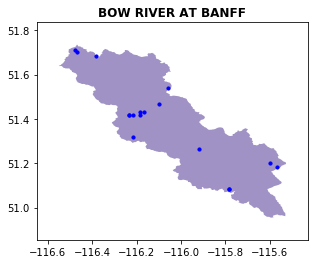

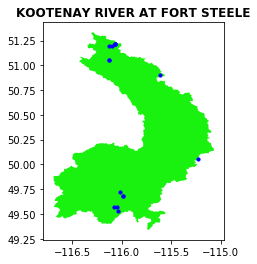

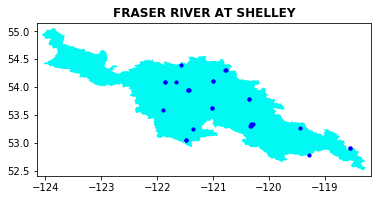

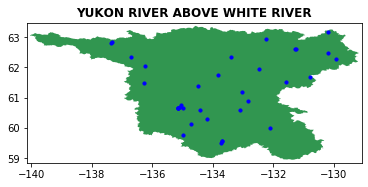

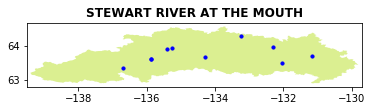

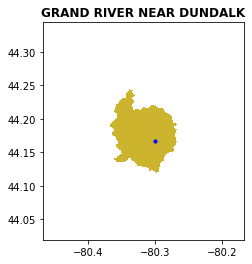

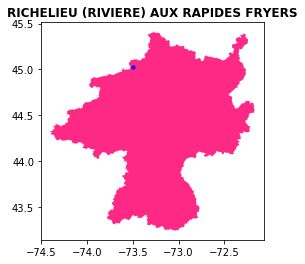

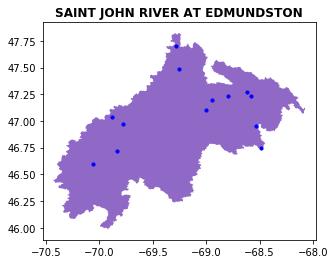

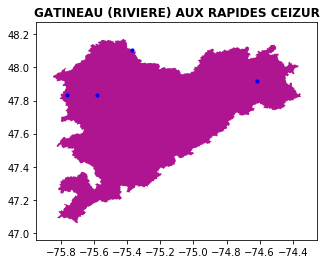

In [10]:
# Plot selected basin, its buffer if applied and extracted SWE stations

for b in basinno:
    minx, miny, maxx, maxy = basins.loc[basins['Station'] == b].geometry.total_bounds
    fig, ax = plt.subplots()
    if buffer == 1:
        basins_buffer[b].plot(ax=ax, facecolor=randomcolors[b][0], alpha=.5)
    basins.loc[basins['Station'] == b].plot(ax=ax, facecolor=randomcolors[b][0])
    SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == b].plot(ax=ax, marker='o', color='b', markersize=10)
    ax.set_xlim(minx - .1, maxx + .1)
    ax.set_ylim(miny - .1, maxy + .1)
    ax.set_title(basins.loc[basins['Station'] == b].StationNam.values[0], fontweight='bold');

In [11]:
# Select SWE data for basins only
# Note: Remove duplicate stations as some stations appear in more than one basin

unique_stations_inbasins = np.unique(SWE_stations_inbasins_gdf["station_id"].values)
SWE_stations_inbasins = SWE_stations.sel(station_id = unique_stations_inbasins)

if buffer == 0:
    SWE_stations_inbasins.attrs['info'] = 'Stations within basins'
elif buffer == 1:
    SWE_stations_inbasins.attrs['info'] = 'Stations within basins + 5km buffer'

display(SWE_stations_inbasins)

<xarray.Dataset>
Dimensions:       (station_id: 124, time: 33816)
Coordinates:
    lat           (station_id) float32 51.416668 51.433334 ... 63.366665
    lon           (station_id) float32 -116.183334 -116.166664 ... -136.68333
    station_name  (station_id) object 'BOW RIVER' ... 'STEWART CROSSING A'
  * time          (time) datetime64[ns] 1928-01-01T18:00:00 ... 2020-07-31T18:00:00
  * station_id    (station_id) object 'ALE-05BA801' ... 'YT-09DD-SC03'
Data variables:
    snw           (time, station_id) float32 ...
Attributes:
    info:     Stations within basins

In [12]:
# # Plotting raw data availability at regular snow season dates
# 
# for b in range(len(basinno)):
#     stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
#     fig, axs = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(8,8))
#     elem = -1
#     colors = ['purple','blue','deepskyblue','green','gold','orange','red']
#     for m in [11,12,1,2,3,4,5]:
#         elem += 1
#         # 1st of month plots
#         datafirstmonth = SWE_stations_inbasins.snw.sel(station_id = stations_in_basin, time=( (SWE_stations_inbasins['time.month'] == m) & (SWE_stations_inbasins['time.day'] == 1) ))
#         datafirstmonthcount = datafirstmonth.count(dim='station_id')/stations_in_basin.size*100
#         axs[elem,0].bar(datafirstmonthcount['time.year'], datafirstmonthcount.data, color=colors[elem])
#         if m == 5:
#             axs[elem,0].set_ylabel('% available stations')
#         axs[elem,0].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(1), fontweight='bold')
#         # 15th of month plots
#         datafifteenthmonth = SWE_stations_inbasins.snw.sel(station_id = stations_in_basin, time=( (SWE_stations_inbasins['time.month'] == m) & (SWE_stations_inbasins['time.day'] == 15) ))
#         datafifteenthmonthcount = datafifteenthmonth.count(dim='station_id')/stations_in_basin.size*100
#         axs[elem,1].bar(datafifteenthmonthcount['time.year'], datafifteenthmonthcount.data, color=colors[elem])
#         axs[elem,1].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(15), fontweight='bold')
#     fig.suptitle(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0], y=1.01, fontweight='bold')
#     plt.tight_layout();

## SWE data pre-processing

### Gap filling

#### Linear interpolation
We first run a simple linear interpolation (with a maximum gap of 16 days) to fill up the smaller data gaps

In [13]:
# Note: this takes a little while to run

SWE_stations_inbasins_interp = SWE_stations_inbasins.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=16))
display(SWE_stations_inbasins_interp)

<xarray.Dataset>
Dimensions:       (station_id: 124, time: 33816)
Coordinates:
    lon           (station_id) float32 -116.183334 -116.166664 ... -136.68333
    station_name  (station_id) object 'BOW RIVER' ... 'STEWART CROSSING A'
  * station_id    (station_id) object 'ALE-05BA801' ... 'YT-09DD-SC03'
    lat           (station_id) float32 51.416668 51.433334 ... 63.366665
  * time          (time) datetime64[ns] 1928-01-01T18:00:00 ... 2020-07-31T18:00:00
Data variables:
    snw           (time, station_id) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    info:     Stations within basins

In [14]:
# # Plotting interpolated data availability at regular snow season dates
# 
# for b in range(len(basinno)):
#     stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
#     fig, axs = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(8,8))
#     elem = -1
#     colors = ['purple','blue','deepskyblue','green','gold','orange','red']
#     for m in [11,12,1,2,3,4,5]:
#         elem += 1
#         # 1st of month plots
#         datafirstmonth = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin, time=( (SWE_stations_inbasins_interp['time.month'] == m) & (SWE_stations_inbasins_interp['time.day'] == 1) ))
#         datafirstmonthcount = datafirstmonth.count(dim='station_id')/stations_in_basin.size*100
#         axs[elem,0].bar(datafirstmonthcount['time.year'], datafirstmonthcount.data, color=colors[elem])
#         if m == 5:
#             axs[elem,0].set_ylabel('% available stations')
#         axs[elem,0].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(1), fontweight='bold')
#         # 15th of month plots
#         datafifteenthmonth = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin, time=( (SWE_stations_inbasins_interp['time.month'] == m) & (SWE_stations_inbasins_interp['time.day'] == 15) ))
#         datafifteenthmonthcount = datafifteenthmonth.count(dim='station_id')/stations_in_basin.size*100
#         axs[elem,1].bar(datafifteenthmonthcount['time.year'], datafifteenthmonthcount.data, color=colors[elem])
#         axs[elem,1].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(15), fontweight='bold')
#     fig.suptitle(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0], y=1.01, fontweight='bold')
#     plt.tight_layout();

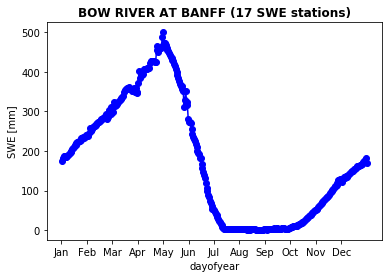

In [15]:
# SWE climatology plots for each basin - day of year averages

# We expect to see warnings as day of year have only NaNs
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    for b in range(1):#len(basinno)):
        stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
        plt.subplots()
        SWEstations_data_climatology = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        SWEstations_data_climatology.plot(color='b', marker='o')
        plt.title(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0]+' ('+str(len(stations_in_basin))+' SWE stations)', fontweight='bold')
        plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
        plt.ylabel('SWE [mm]');

### Gap filling using donor stations
This is the heavy lifting gap filling, in order to have an as stationary dataset as possible. For each target station (with missing data) we identify a donor station based on 2 criteria: 1) a high correlation value between the donor and target station (>0.6) and 2) a long enough timeseries for the donor station. Once identified, the donor station values are used to fill up gaps in the recicipient station timeseries.

In [16]:
# TESTS BELOW FOR BOW AT BANFF ONLY

# Select specific basins given their station numbers and display their info in a GeoDataFrame
basinshp = gpd.read_file("/Users/lla068/Desktop/data_driven_forecasting/basins/Bow_Banff.shp")
display(basinshp)

,Station,StationNam,Stn_UID,Shp_Area,Shp_Perime,elev_media,elev_min,elev_max,geometry
0,05BB001,BOW RIVER AT BANFF,05BB001_1,2209.593735,340.817572,2162.300049,1380.200073,3527.5,"POLYGON Z ((-116.45854 51.72693 0.00000, -116...."


In [17]:
# # Tests for Bow @Banff

# test_swe_stations = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[0]].station_id.values
# SWE_stations_meastype = SWE_stations_raw.type_mes.sel(station_id=test_swe_stations)
# display(SWE_stations_meastype)

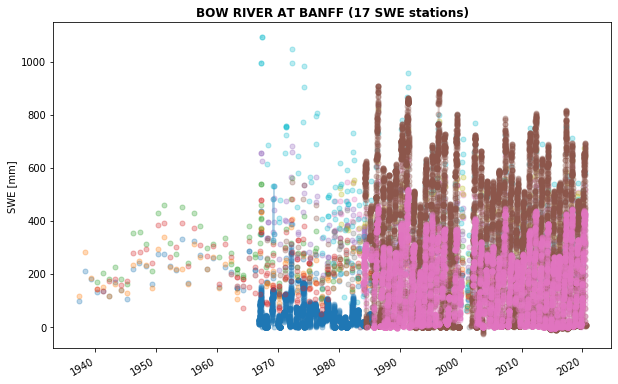

In [18]:
# Let's plot the interpolated SWE station data, prior to this gap filling
# Note: To plot results for all basins looking at replace range(0,1) by range(len(basinno))

for b in range(0,1):
    stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
    plt.figure(figsize=(10,6))
    for s in stations_in_basin:
        SWE_stations_inbasins_interp.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=5)
    plt.title(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0]+' ('+str(len(stations_in_basin))+' SWE stations)', fontweight='bold')
    plt.ylabel('SWE [mm]')
    plt.xlabel('');

In [19]:
# for b in range(0,1):
#     stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
#     print('Measurement types for stations in basin:')
# #     plt.subplots()
#     for s in stations_in_basin:
#         print(s, ':', SWE_stations_meastype.sel(station_id = s).data)
# #         plt.scatter(SWE_stations_inbasins_interp.snw.sel(station_id = s).dropna(dim='time', how='all').time, [SWE_stations_meastype.sel(station_id = s).data]*len(SWE_stations_inbasins_interp.snw.sel(station_id = s).dropna(dim='time', how='all').time), alpha=.1)
# #     plt.title(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0]+' ('+str(len(stations_in_basin))+' SWE stations)', fontweight='bold')
# #     plt.ylabel('Measurement type');
#     print('\nLegend:')
#     print(SWE_stations_meastype.attrs['description'])

In [20]:
# test_swe_stations = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[0]].station_id.values
# SWE_stations_elev = SWE_stations_raw.elevation.sel(station_id=test_swe_stations)
# display(SWE_stations_elev)

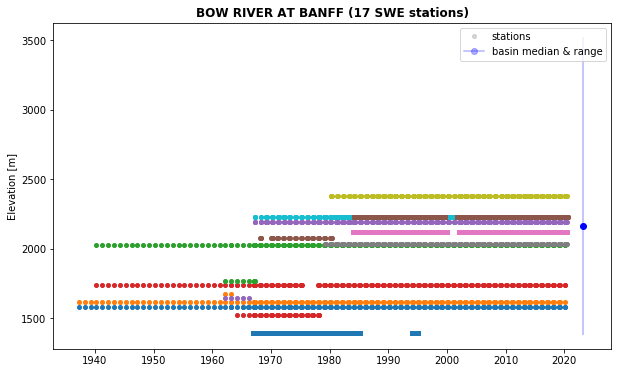

In [21]:
# Plotting the basin's elevation & that of SWE stations within the basin

for b in range(0,1):
    stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
    SWE_stations_elev = SWE_stations_raw.elevation.sel(station_id=stations_in_basin)
    plt.figure(figsize=(10,6))
    for s in stations_in_basin:
        time_with_data = SWE_stations_inbasins_interp.snw.sel(station_id = s).dropna(dim='time', how='all').time
        plt.plot(time_with_data, [SWE_stations_elev.sel(station_id = s).data]*len(time_with_data), marker='o', markersize=4, lw=0)
    
    newtime = pd.Timestamp(SWE_stations_inbasins_interp.time[-1].values) + pd.DateOffset(months=32)
    errors = np.zeros((2,1))
    errors[0,0] = basinshp['elev_media'].values[0] - basinshp['elev_min'].values[0]
    errors[1,0] = basinshp['elev_max'].values[0] - basinshp['elev_media'].values[0]
    plt.scatter(newtime, basinshp['elev_media'].values[0], color='blue')
    plt.errorbar(newtime, basinshp['elev_media'].values[0], yerr=errors, color='blue', alpha=.3, ls='none')
    
    station_eg_line, = plt.plot(time_with_data, [-999]*len(time_with_data), alpha=.3, color='grey', label='stations', marker='o', markersize=4, lw=0)
    basin_eg_line, = plt.plot(time_with_data, [-999]*len(time_with_data), alpha=.3, color='blue', label='basin median & range', marker='o')

    plt.ylim(basinshp['elev_min'].values[0]-100,basinshp['elev_max'].values[0]+100)
    plt.title(basins.loc[basins['Station'] == basinno[b]].StationNam.values[0]+' ('+str(len(stations_in_basin))+' SWE stations)', fontweight='bold')
    plt.ylabel('Elevation [m]')
    plt.legend();

If we were to calculate the basin means from these station values, we would get highly variable values through time, depending on which station was available when. To illustrate this, let's calculate the basin averages now to see what it looks like.

In [22]:
def monthly_basin_averages(SWE_data):

    # Dictionary to save the normalized values corresponding to 0 for each basin - these will be used to fill up months we can't see SWE data for before running the forecasts
    zero_norms = {}

    # We expect to see warnings as some years have only NaNs
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        for b in range(0,1):

            # Extracts only SWE stations in basin
            stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
            SWE_data_aggreg = SWE_data.snw.sel(station_id = stations_in_basin)

            # SWE monthly means for each station in basin
            SWE_data_aggreg = SWE_data_aggreg.resample(time="1MS").mean(skipna = True)
            
            # Finding the normalized value corresponding to 0 to fill up NAs
            zero_norm = (0 - SWE_data_aggreg.mean(skipna = True)) / SWE_data_aggreg.std(skipna = True)
            zero_norms[basinno[b]] = zero_norm.values
            
            # Normalizing data to be able to make basin means from all stations
            SWE_data_aggreg = (SWE_data_aggreg - SWE_data_aggreg.mean(skipna = True)) / SWE_data_aggreg.std(skipna = True)
            
            # Calculating basin means
            SWE_data_aggreg = SWE_data_aggreg.mean(dim='station_id', skipna=True)
            
            # Filling up NAs with the normalized zero SWE value
            SWE_data_aggreg = SWE_data_aggreg.fillna(zero_norm)

            # Tidying up the xarray
            SWE_data_aggreg = SWE_data_aggreg.rename('SWE')
            SWE_data_aggreg = SWE_data_aggreg.assign_coords({"time":SWE_data_aggreg.time,"basin_id":basinno[b]})
            SWE_data_aggreg = SWE_data_aggreg.expand_dims('basin_id')

            # Concatenating basins into the same dataset
            if b == 0:
                SWE_aggreg_ds = SWE_data_aggreg
            else:
                SWE_aggreg_ds = xr.concat((SWE_aggreg_ds, SWE_data_aggreg), dim='basin_id')

    # Adding a few attributes to the dataset
    SWE_aggreg_ds.attrs['info'] = 'Normalized basin monthly SWE (snow water equivalent) averages. Calculated from available SWE data from stations within basins. Note: months with only missing values were assigned a zero monthly average in order to be able to perform the regression.'
    SWE_aggreg_ds.attrs['units'] = 'kg m-2 or mm'

    return SWE_aggreg_ds, zero_norms

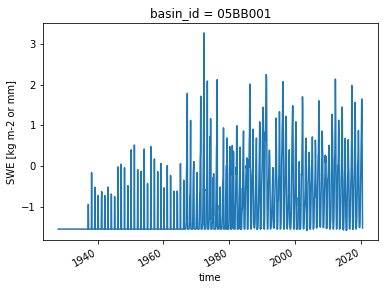

In [23]:
SWE_aggreg_ds, zero_norms = monthly_basin_averages(SWE_stations_inbasins_interp)

# Plotting the data for an example basin
plt.figure()
SWE_aggreg_ds.sel(basin_id='05BB001').plot();

As we can see these data don't look stationary, which isn't great for forecasting. In fact we can check this.

<xarray.DataArray (time: 1111)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time      (time) datetime64[ns] 1928-01-01 1928-02-01 ... 2020-07-01
    basin_id  <U7 '05BB001'

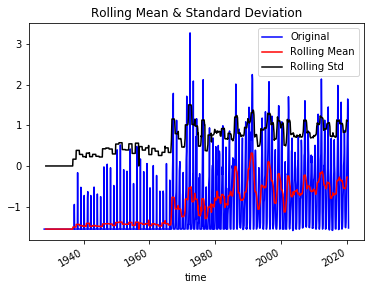

Results of Dickey-Fuller Test:
Test Statistic                   -2.360680
p-value                           0.153143
#Lags Used                       22.000000
Number of Observations Used    1088.000000
Critical Value (1%)              -3.436375
Critical Value (5%)              -2.864200
Critical Value (10%)             -2.568186
dtype: float64


In [24]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(time=12, center=True).mean()
    rolstd = timeseries.rolling(time=12, center=True).std()
    
    display(rolmean)
    
    #Plot rolling statistics:
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(SWE_aggreg_ds.sel(basin_id='05BB001'))

This timeseries is not stationary because its statistical properties change over time. In other words, it has non constant mean and variance. The Dickey-Fuller test is a statistical test that we run to determine if a time series is stationary or not. It tests the null hypothesis that the timeseries is non-stationary. If p>0, the process is not stationary. Otherwise, p=0, the null hypothesis is rejected, and the process is considered to be stationary. Here, the test statistic is larger than all critical values. That tells us that we are at most 89% confident that this series is indeed not stationary.

Now the heavy lifting!

In [25]:
# Criterium 1: We calculate correlations between stations, requesting a minimum of X daily data points defined by min_periods

# We first need to transform the dataset to a pandas dataframe
SWE_interp_df = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin).to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw']

SWE_interp_corr_df = SWE_interp_df.corr(method='pearson', min_periods=24)

# Only displaying the first few rows as this is a lot of data
display(SWE_interp_corr_df.head())

station_id,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,ALE-05BB803P,ALE-05CA805P,SCD-AL003,SCD-AL055,SCD-AL091,SCD-AL142,SCD-AL148
station_id,,,,,,,,,,,,,,,,,
ALE-05BA801,1.000000,0.940243,0.933410,0.929224,NaN,NaN,NaN,NaN,NaN,0.685002,0.781933,0.799008,0.545369,NaN,NaN,NaN,NaN
ALE-05BA802,0.940243,1.000000,0.945591,0.935247,0.854602,NaN,NaN,0.884967,NaN,0.719590,0.839061,0.858316,0.515219,NaN,NaN,NaN,NaN
ALE-05BA806,0.933410,0.945591,1.000000,0.931832,0.921690,NaN,0.946881,0.912020,0.912817,0.734384,0.896314,0.933552,0.552164,NaN,NaN,NaN,NaN
ALE-05BA808,0.929224,0.935247,0.931832,1.000000,NaN,NaN,NaN,NaN,NaN,0.755617,0.831312,0.838935,0.499029,NaN,NaN,NaN,NaN
ALE-05BA810,NaN,0.854602,0.921690,NaN,1.000000,NaN,0.905508,0.947187,0.726848,0.789208,0.837083,0.925807,0.404403,NaN,NaN,NaN,NaN


In [26]:
# Criterium 2: We count the length of each station's timeseries (excluding NAs)

time_period = []

for s in range(SWE_interp_corr_df.shape[1]):
    start = SWE_interp_df.iloc[:,s].dropna().index[0]
    end = SWE_interp_df.iloc[:,s].dropna().index[-1]
    period = end - start
    time_period.append(period.days)

SWE_interp_datalength_series = pd.Series(time_period, index=SWE_interp_corr_df.index).sort_values(ascending=False)

display(SWE_interp_datalength_series)

station_id
ALE-05BA802     30290
ALE-05BA801     30282
ALE-05BA806     29187
ALE-05BA808     29187
ALE-05BA810     19419
ALE-05BB803     19417
ALE-05BA813     15067
ALE-05BA812     15038
ALE-05BA814     14673
ALE-05CA805P    13308
ALE-05BB803P    13288
SCD-AL003       10327
SCD-AL142        5112
ALE-05BA811      4444
SCD-AL091        1829
SCD-AL148        1461
SCD-AL055         364
dtype: int64

In [27]:
# We then rank the donor stations in terms of their correlation to the target station
# Note: we set a lower threshold of 0.6 as minimum correlation

def ranking_donor_stations_corr(target_station_id):
    
    target_station_index = SWE_interp_corr_df.columns.get_loc(str(target_station_id))
    print('target station id & index:', target_station_id, ',', target_station_index)

    length = list(np.arange(SWE_interp_corr_df.shape[0]))
    length.remove(target_station_index)

    donor_stations_corr_series = SWE_interp_corr_df.iloc[length,target_station_index].dropna().sort_values(ascending=False)
    donor_stations_corr_series = donor_stations_corr_series[donor_stations_corr_series >= 0.6]
    
    return target_station_index, donor_stations_corr_series

In [28]:
# We run a test for the highest station in this basin

highest_station = SWE_stations_elev.sel(station_id = stations_in_basin).station_id[SWE_stations_elev.sel(station_id = stations_in_basin).argmax()].data
target_station_index, donor_stations_corr_series = ranking_donor_stations_corr(highest_station)

display(donor_stations_corr_series)

target station id & index: ALE-05BA814 , 8


station_id
ALE-05BA806     0.912817
ALE-05BB803P    0.886694
ALE-05BA812     0.877370
ALE-05BB803     0.816166
ALE-05BA810     0.726848
ALE-05BA813     0.660474
Name: ALE-05BA814, dtype: float64

In [29]:
# To find the optimal donor station, we multiply the correlation by the data length of each donor station

def finding_optimal_donor(donor_stations_corr_series, SWE_interp_datalength_series):

    best_donors = (donor_stations_corr_series * SWE_interp_datalength_series).sort_values(ascending=False)
    optimal_donor = best_donors.index[0]
    return optimal_donor

optimal_donor = finding_optimal_donor(donor_stations_corr_series, SWE_interp_datalength_series)
print(optimal_donor)

ALE-05BA806


We are now going to fit a regression model between the target and donor data to fill out the gaps in the target dataset.
But before we do this, we need to split the data in training (to fit the model) and testing (to test the model fit) datasets.

In [30]:
# Splitting the target and donor timeseries in testing (all NAs datapoints in the target dataset) and training (all other datapoints) datasets

def splitting_data_train_test(target_station_index, optimal_donor):

    # Train - test split
    target_train = SWE_interp_df.iloc[:,target_station_index].dropna()
    target_test = SWE_interp_df.iloc[:,target_station_index][SWE_interp_df.iloc[:,target_station_index].isnull()]

    donor_train = SWE_interp_df[optimal_donor][target_train.index]
    donor_test = SWE_interp_df[optimal_donor][target_test.index]
    
    # Merging target and donor datasets for the regression
    train_dataset = pd.concat([target_train.rename('target'), donor_train.rename('donor')], axis=1)
    test_dataset = pd.concat([target_test.rename('target'), donor_test.rename('donor')], axis=1, names=['target', 'donor'])
    
    return train_dataset, test_dataset

train_dataset, test_dataset = splitting_data_train_test(target_station_index, optimal_donor)
display(train_dataset, test_dataset)

,target,donor
time,,
1980-03-27 18:00:00,521.0,NaN
1980-04-29 18:00:00,500.0,NaN
1980-05-29 18:00:00,386.0,NaN
1981-04-02 18:00:00,371.0,NaN
1981-05-29 18:00:00,363.0,NaN
...,...,...
2019-05-29 18:00:00,462.0,NaN
2020-02-03 18:00:00,469.0,NaN
2020-02-26 18:00:00,512.0,NaN


,target,donor
time,,
1928-01-01 18:00:00,NaN,NaN
1928-01-02 18:00:00,NaN,NaN
1928-01-03 18:00:00,NaN,NaN
1928-01-04 18:00:00,NaN,NaN
1928-01-05 18:00:00,NaN,NaN
...,...,...
2020-07-27 18:00:00,NaN,NaN
2020-07-28 18:00:00,NaN,NaN
2020-07-29 18:00:00,NaN,NaN


In [31]:
# We can now fit an OLS model based on the donor and target training data

def fitting_model(train_dataset):

    # OLS model fitting on the training dataset
    ols_model = smf.ols(formula = 'target ~ 1 + donor', data = train_dataset)
    model_fit = ols_model.fit()
    
    return model_fit

model_fit = fitting_model(train_dataset)
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     124.9
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           3.25e-11
Time:                        09:59:04   Log-Likelihood:                -144.35
No. Observations:                  27   AIC:                             292.7
Df Residuals:                      25   BIC:                             295.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.9296     38.294     -0.155      0.8

In [32]:
# Based on the model above, we can now predict the target's missing values

# We first make a copy of the original data so as not to mix observed with predicted values for the rest of the gap filling
SWE_interp_gapfilling_df = SWE_interp_df.copy()

def predicting_target_missing_values(model_fit, test_dataset, SWE_interp_gapfilling_df):

    # Predicting the target missing values in the test dataset
    fcst_target = model_fit.get_prediction(exog=test_dataset)
    
    # We first need to make sure that there are no negative values in the predicted data
    fcst_target.predicted_mean[fcst_target.predicted_mean<0] = 0

    # Saving predictions to copied target dataset
    SWE_interp_gapfilling_df.iloc[:,target_station_index].loc[test_dataset['donor'].dropna().index] = fcst_target.predicted_mean
    
    return SWE_interp_gapfilling_df

SWE_interp_gapfilling_df = predicting_target_missing_values(model_fit, test_dataset, SWE_interp_gapfilling_df)

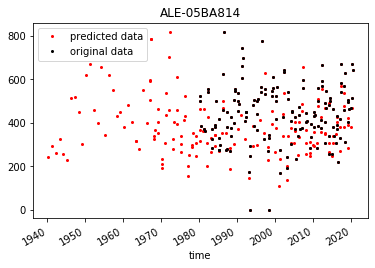

In [33]:
# Plotting predicted values for our text station to check results

SWE_interp_gapfilling_df.iloc[:,target_station_index].plot(color='r', marker='o', ms=2, label='predicted data', lw=0)
SWE_interp_df.iloc[:,target_station_index].plot(color='k', marker='o', ms=2, label='original data', lw=0)
plt.title(SWE_interp_df.columns[target_station_index])
plt.legend();

target station id & index: ALE-05BA801 , 0
target station id & index: ALE-05BA802 , 1
target station id & index: ALE-05BA806 , 2
target station id & index: ALE-05BA808 , 3
target station id & index: ALE-05BA810 , 4
target station id & index: ALE-05BA811 , 5
target station id & index: ALE-05BA812 , 6
target station id & index: ALE-05BA813 , 7
target station id & index: ALE-05BA814 , 8
target station id & index: ALE-05BB803 , 9
target station id & index: SCD-AL003 , 12
target station id & index: SCD-AL055 , 13


/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


target station id & index: SCD-AL091 , 14
target station id & index: SCD-AL142 , 15
target station id & index: SCD-AL148 , 16
target station id & index: ALE-05BB803P , 10
target station id & index: ALE-05CA805P , 11


<xarray.Dataset>
Dimensions:     (station_id: 17, time: 13608)
Coordinates:
  * time        (time) datetime64[ns] 1937-03-30T18:00:00 ... 2020-07-30T18:00:00
  * station_id  (station_id) object 'ALE-05BA801' 'ALE-05BA802' ... 'SCD-AL148'
Data variables:
    snw         (time, station_id) float32 97.0 117.0 153.46945 ... nan nan nan

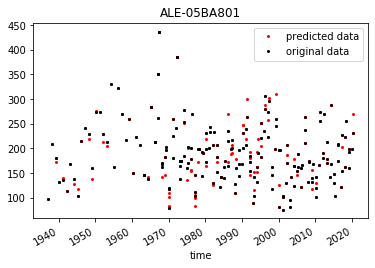

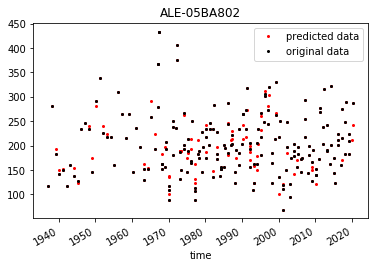

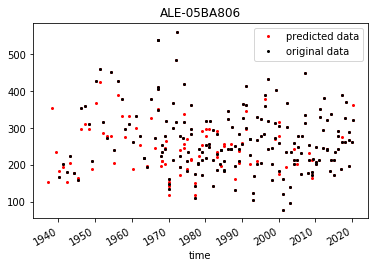

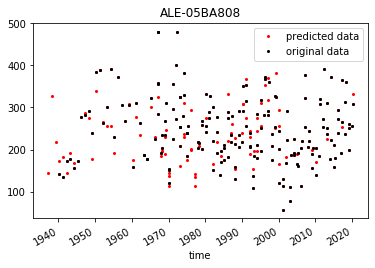

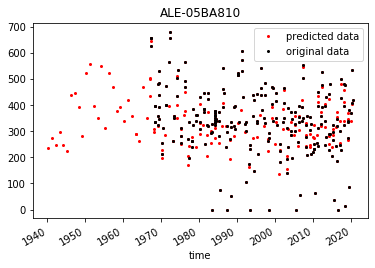

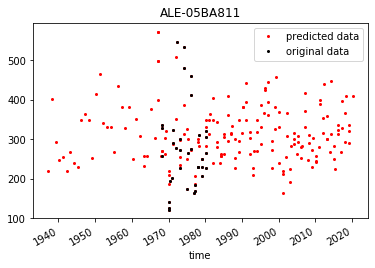

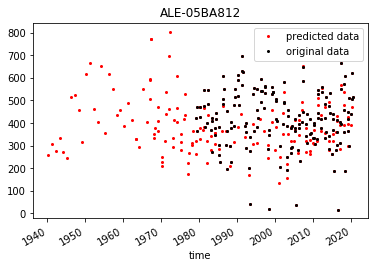

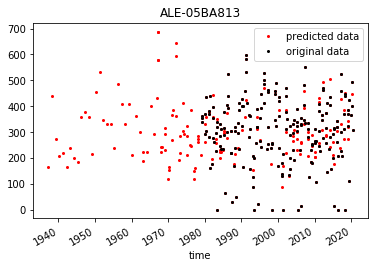

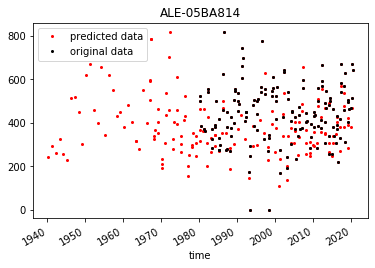

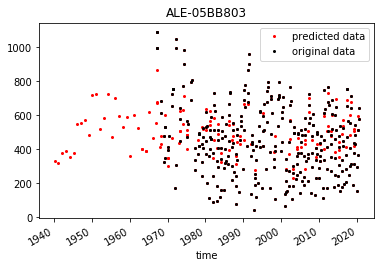

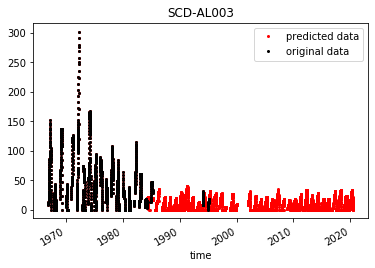

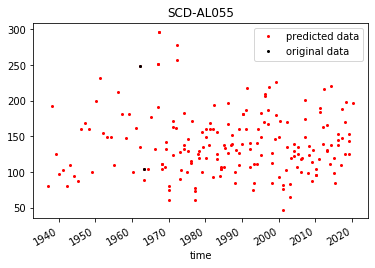

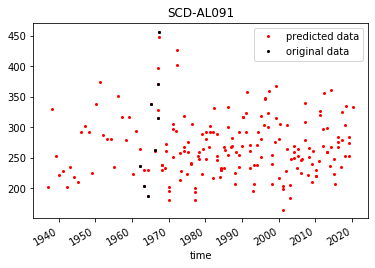

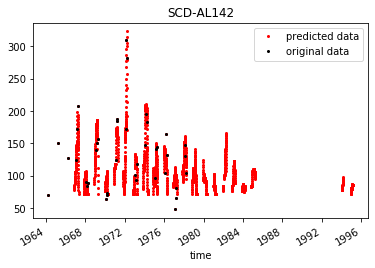

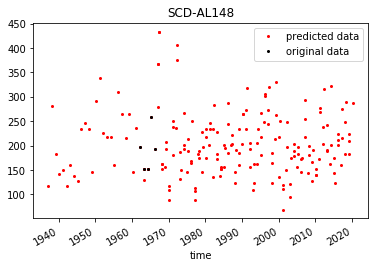

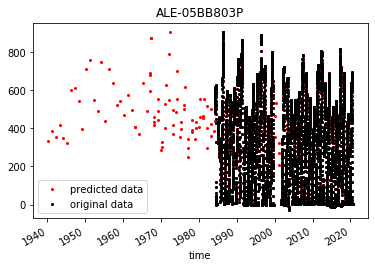

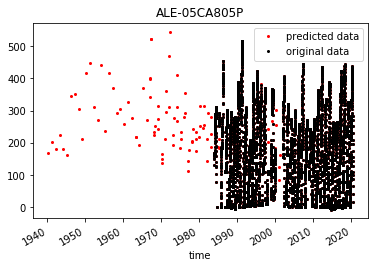

In [34]:
# Filling up missing stations data with other stations data using functions defined above

# We first make a copy of the original data so as not to mix observed with predicted values for the rest of the gap filling
SWE_interp_gapfilling_df = SWE_interp_df.copy()

for ts in stations_in_basin:

    # Identifying the optimal station for target station ts based on correlation and donor timeseries length
    target_station_index, donor_stations_corr_series = ranking_donor_stations_corr(ts)
    optimal_donor = finding_optimal_donor(donor_stations_corr_series, SWE_interp_datalength_series)
    
    # We split the data into train and test timeseries
    train_dataset, test_dataset = splitting_data_train_test(target_station_index, optimal_donor)
    
    # Fitting the OLS regression model between the target and donor train datasets
    model_fit = fitting_model(train_dataset)
    
    # Predicting the target missins values based on the new regression model and saving to new dataset
    SWE_interp_gapfilling_df = predicting_target_missing_values(model_fit, test_dataset, SWE_interp_gapfilling_df)
    
    # Plotting to check the results
    plt.figure()
    SWE_interp_gapfilling_df.iloc[:,target_station_index].plot(color='r', marker='o', ms=2, label='predicted data', lw=0)
    SWE_interp_df.iloc[:,target_station_index].plot(color='k', marker='o', ms=2, label='original data', lw=0)
    plt.title(SWE_interp_df.columns[target_station_index])
    plt.legend();
    
# Converting df to xarray dataset (required format for data aggregation - next step)
SWE_interp_gapfilling_ds = SWE_interp_gapfilling_df.stack().to_xarray().to_dataset(name='snw')
display(SWE_interp_gapfilling_ds)

As you can see, this helps us fill up a lot of gaps in the original SWE dataset. Let's check what the basin normalized averages look like to check that this has also helped rectify the stationarity.

### Data aggregation

#### Method 1 - Basin averages
Basin averages for each snow season date, after normalization (in case very high or low SWE data occasionally)

In [35]:
# # We expect to see warnings as some years have only NaNs
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=RuntimeWarning)

#     for b in range(len(basinno)):
#         stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
#         for (m,d) in [(11,15), (12,1), (12,15), (1,1), (1,15), (2,1), (2,15), (3,1), (3,15), (4,1), (4,15), (5,1), (5,15)]:
#             data = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin, time =( (SWE_stations_inbasins_interp['time.month'] == m) & (SWE_stations_inbasins_interp['time.day'] == d) ))
#             # Normalize data
#             datanorm = (data - data.mean(skipna = True)) / data.std(skipna = True)
#             #print('Normalised data mean:',np.nanmean(datanorm.data),', std dev:',np.nanstd(datanorm.data))
#             # Calculate basin mean
#             basinmean = datanorm.mean(dim='station_id', skipna=True)
#             # New coordinates and dimensions
#             if m == 11 or m == 12:
#                 years = basinmean['time.year'].data + 1
#             else:
#                 years = basinmean['time.year'].data
#             basinmean = basinmean.drop_vars('time')
#             basinmean = basinmean.rename('SWE_'+basinno[b])
#             basinmean = basinmean.assign_coords({"time":years,"doy":"{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(d)})
#             basinmean = basinmean.expand_dims('doy')
#             # For each basin, save basin means to new DataArray
#             if (m,d) == (11,15):
#                 SWE_stations_basinmeans_da = basinmean
#             elif (m,d) != (11,15):
#                 SWE_stations_basinmeans_da = xr.concat((SWE_stations_basinmeans_da, basinmean), dim='doy')
#         SWE_stations_basinmeans_da.attrs['units'] = 'kg m-2 or mm'
#         # Merge all basins means DataArrays into single Dataset
#         if (b == 0):
#             SWE_stations_basinmeans_ds = SWE_stations_basinmeans_da
#         elif (b != 0):
#             SWE_stations_basinmeans_ds = xr.merge([SWE_stations_basinmeans_ds, SWE_stations_basinmeans_da])

# SWE_stations_basinmeans_ds.time.attrs['info'] = 'Year of snow season end'
# SWE_stations_basinmeans_ds.doy.attrs['info'] = 'Snow season date'
# display(SWE_stations_basinmeans_ds)

#### Method 2 - Stations snow season maxima
Maxima for each snow season and snow station

In [36]:
# years = np.arange(SWE_stations_inbasins_interp['time.year'].data[0], SWE_stations_inbasins_interp['time.year'].data[-1]-1,1)

# for b in range(len(basinno)):
#     stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[b]].station_id.values
#     for year in years:
#         data = SWE_stations_inbasins_interp.snw.sel(station_id = stations_in_basin, time = slice(str(year)+'-11-15',str(year+1)+'-5-1'))
#         data_max = data.max(dim='time', skipna='True')
#         if year == SWE_stations_inbasins_interp['time.year'].data[0]:
#             SWE_stations_snowseasonmax_da = data_max
#         else:
#             SWE_stations_snowseasonmax_da = xr.concat((SWE_stations_snowseasonmax_da, data_max), dim='time')
#     SWE_stations_snowseasonmax_da = SWE_stations_snowseasonmax_da.rename('SWE_'+basinno[b])
#     SWE_stations_snowseasonmax_da = SWE_stations_snowseasonmax_da.assign_coords(time=("time", years+1))
#     SWE_stations_snowseasonmax_da.attrs['units'] = 'kg m-2 or mm'
    
#     # Merge all basins means DataArrays into single Dataset
#     if (b == 0):
#         SWE_stations_snowseasonmax_ds = SWE_stations_snowseasonmax_da
#     elif (b != 0):
#         SWE_stations_snowseasonmax_ds = xr.merge([SWE_stations_snowseasonmax_ds, SWE_stations_snowseasonmax_da])

# SWE_stations_snowseasonmax_ds.time.attrs['info'] = 'Year of snow season end'
        
# display(SWE_stations_snowseasonmax_ds)

In [37]:
# #Test print to visualize season max results

# stations_in_basin = SWE_stations_inbasins_gdf.loc[SWE_stations_inbasins_gdf['basin'] == basinno[0]].station_id.values
# teststation = stations_in_basin[0]
# data = SWE_stations_inbasins_interp.snw.sel(station_id = teststation, time=slice('1980-11-15','1990-5-1'))
# data.plot(marker='o', label='daily values')
# maxdata = SWE_stations_snowseasonmax_ds.SWE_05BB001.sel(station_id = teststation, time=slice("1981","1990"))
# yearsselec = pd.date_range(start='1981-01-01', end='1990-01-01', freq='AS')
# plt.plot(yearsselec,maxdata.data, marker='o', label='snow season max.')
# plt.legend()
# plt.title(basins.loc[basins['Station'] == basinno[0]].StationNam.values[0], fontweight='bold');

#### Method 3 -  Basin monthly averages
Basin monthly averages, after normalization (in case very high or low SWE data occasionally)

In [38]:
SWE_normmonthlybasinmeans_ds, zero_norms = monthly_basin_averages(SWE_interp_gapfilling_ds)
display(SWE_normmonthlybasinmeans_ds)

<xarray.DataArray 'SWE' (basin_id: 1, time: 1001)>
array([[-0.65136013, -1.48851374, -1.48851374, ...,  1.0725916 ,
        -0.71222019, -1.46164527]])
Coordinates:
  * time      (time) datetime64[ns] 1937-03-01 1937-04-01 ... 2020-07-01
  * basin_id  (basin_id) <U7 '05BB001'
Attributes:
    info:     Normalized basin monthly SWE (snow water equivalent) averages. ...
    units:    kg m-2 or mm

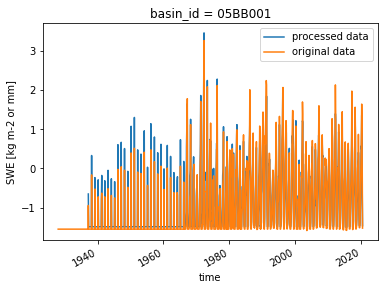

In [39]:
# Plotting the data for an example basin - only basin it's working for now

SWE_normmonthlybasinmeans_ds.sel(basin_id='05BB001').plot(label='processed data')
SWE_aggreg_ds.sel(basin_id='05BB001').plot(label='original data')
plt.legend();

<xarray.DataArray (time: 1001)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time      (time) datetime64[ns] 1937-03-01 1937-04-01 ... 2020-07-01
    basin_id  <U7 '05BB001'

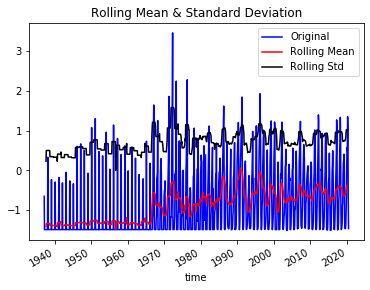

Results of Dickey-Fuller Test:
Test Statistic                  -3.175320
p-value                          0.021458
#Lags Used                      13.000000
Number of Observations Used    987.000000
Critical Value (1%)             -3.436993
Critical Value (5%)             -2.864473
Critical Value (10%)            -2.568332
dtype: float64


In [40]:
# Let's check the new data stationarity

test_stationarity(SWE_normmonthlybasinmeans_ds.sel(basin_id='05BB001'))

This is quite a bit better compared to the original data. We are happy to proceed with the forecasting in the next Notebook!

# Saving data

In [42]:
# Store data for use in other Notebooks
# %store SWE_stations_basinmeans_ds
# %store SWE_stations_snowseasonmax_ds
%store SWE_normmonthlybasinmeans_ds
%store zero_norms

Stored 'SWE_normmonthlybasinmeans_ds' (DataArray)
Stored 'zero_norms' (dict)
